In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.fft as fft
import seaborn as sns
sns.set()

from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tqdm.notebook import tqdm

import sys
sys.path.append("/home/evangelos/workspace/Channel_Charting/")
from tools import utils
from src.models import supervised_classifier, supervised_regressor
from src.utils.data_preparation import SupervisedDataset

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam


In [4]:
# load datasets
(raw_taps, raw_phi, raw_theta, raw_rx_positions, raw_tx_positions) = utils.load_datasets()

In [5]:
#fourier transform and undersample taps
raw_freq_taps = fft.fft(raw_taps , workers=-1)[:,:,::2]

In [6]:
def preprocessing(data, first_data, rx_positions, padding=True):
    data = utils.drop_top_right(data, rx_positions)
    data = utils.standarize(data)
    data = utils.fillna(data)
    if padding:
        data = utils.zero_padding_as(data, first_data)
    #data = utils.take_norm(data)
    data = reduce_to_mean_std(data)
    
    return data

def reduce_to_mean_std(x):
    return np.stack([np.mean(x,axis=1), 
                          np.std(x,axis=1)], axis=1)

In [7]:
taps = preprocessing(raw_freq_taps, raw_freq_taps, raw_rx_positions)
taps = np.hstack([np.real(taps), np.imag(taps)])
phi = preprocessing(raw_phi, taps, raw_rx_positions)
theta = preprocessing(raw_theta, taps, raw_rx_positions)

y  = preprocessing(raw_rx_positions, taps, raw_rx_positions, padding=False)[:,:2]
X = np.hstack([taps])

In [8]:
#train test split
train_X, test_X ,train_y, test_y = train_test_split(X, y)
train_DS = SupervisedDataset(train_X, train_y)
test_DS = SupervisedDataset(test_X, test_y)

In [9]:
train_loader = DataLoader(train_DS, batch_size=32)
test_loader = DataLoader(test_DS)

In [10]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [11]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=train_DS.channels(), 
                               out_channels=64, 
                               kernel_size=8,
                              stride=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=2, stride=2)
        self.lin1 = nn.Linear(352, 32)
        self.z_Loc = nn.Linear(32,latent_dim)
        self.z_scale = nn.Linear(32,latent_dim)
        
    def forward(self, x):
        x = F.normalize(F.selu(self.conv1(x)))
        x = F.normalize(F.selu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.selu(self.lin1(x))

        z_loc = F.softplus(self.z_Loc(x))
        z_scale = torch.exp(self.z_scale(x))
        return z_loc, z_scale
    

In [12]:
# test encoder
enc = Encoder()
sample = train_DS[:1][0]
latent = enc(sample)

In [13]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Decoder, self).__init__()
        self.lin1 = nn.Linear(latent_dim ,32)
        self.lin2 = nn.Linear(32, 352)
        
        self.deconv1 = nn.ConvTranspose1d(32, 64, 2, 2)
        self.deconv2 = nn.ConvTranspose1d(64, train_DS.channels(), 8, 2)   
        
    def forward(self, x):
        x = F.selu(self.lin1(x))
        x = F.selu(self.lin2(x))        
        x = x.view(x.shape[0], 32, 11)
        x = F.selu(self.deconv1(x))
        x = F.selu(self.deconv2(x))        
        
        return x

In [14]:
# test decoder
dec = Decoder(2)
reconstructed = dec(latent[0])
reconstructed.shape, sample.shape

(torch.Size([1, 4, 50]), torch.Size([1, 4, 50]))

In [15]:
# define the model p(x|z)p(z)
def model(self, x):
    # register PyTorch module `decoder` with Pyro
    pyro.module("decoder", self.decoder)
    with pyro.plate("data", x.shape[0]):
        # setup hyperparameters for prior p(z)
        z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
        z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
        # sample from prior (value will be sampled by guide when computing the ELBO)
        z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
        # decode the latent code z
        recostructed = self.decoder(z)
        # score against actual images
        pyro.sample("obs", dist.Bernoulli(reconstructed).to_event(1), obs=x.reshape(-1, torch.flatten.shape[1]))


In [16]:
# define the guide (i.e. variational distribution) q(z|x)
def guide(self, x):
    # register PyTorch module `encoder` with Pyro
    pyro.module("encoder", self.encoder)
    with pyro.plate("data", x.shape[0]):
        # use the encoder to get the parameters used to define q(z|x)
        z_loc, z_scale = self.encoder.forward(x)
        # sample the latent code z
        pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))


In [17]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            reconstructed = self.decoder(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(torch.flatten(reconstructed)).to_event(1), 
                            obs=torch.flatten(x).shape[0])

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        reconstructed = self.decoder(z)
        return reconstructed


In [18]:
vae = VAE(32)
optimizer = Adam({"lr": 1.0e-4})
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

In [19]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in tqdm(train_loader):
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in tqdm(test_loader):
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [20]:
# Run options
LEARNING_RATE = 1.0e-4
USE_CUDA = False
smoke_test = False
# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 100
TEST_FREQUENCY = 5
# clear param store
pyro.clear_param_store()

In [57]:
# setup the VAE
vae = VAE(32, use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in tqdm(range(NUM_EPOCHS)):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))



[epoch 000]  average training loss: 354607271.9445



[epoch 000] average test loss: 346073.7790



[epoch 001]  average training loss: 354484405.3163



[epoch 002]  average training loss: 354810610.2685



[epoch 003]  average training loss: 354626955.3801



[epoch 004]  average training loss: 354704002.6124



[epoch 005]  average training loss: 354717602.5300



[epoch 005] average test loss: 346629.3911


KeyboardInterrupt: 

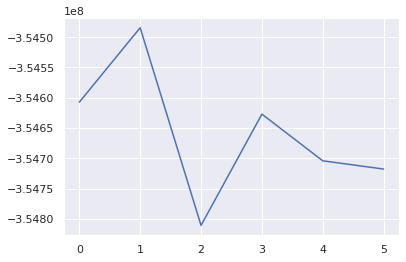

In [58]:
plt.plot(train_elbo)

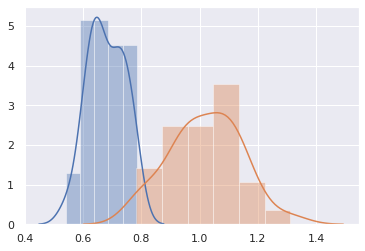

In [59]:
import seaborn as sns
sns.distplot(vae.encoder(sample)[0].detach())
sns.distplot(vae.encoder(sample)[1].detach())

In [60]:
enc = vae.encoder(sample)

In [61]:
enc[1]

tensor([[0.9547, 0.9314, 1.0283, 1.1913, 0.8193, 1.1267, 1.1893, 0.9039, 0.7831,
         1.0989, 0.9092, 0.9656, 1.0962, 1.1140, 1.3113, 0.9972, 1.0252, 0.9411,
         1.0608, 0.9950, 1.0910, 1.0319, 0.8002, 1.1180, 0.8346, 1.0878, 1.1577,
         1.0660, 1.1215, 0.9842, 0.9322, 0.9485]], grad_fn=<ExpBackward>)

In [62]:
svi.guide(sample)

In [63]:
d = pyro.get_param_store().get_all_param_names()

In [65]:
latent = vae.encoder(test_DS[:][0])
positions = test_DS[:][1]

In [66]:
from sklearn.cluster import KMeans
km = KMeans(8)
label = km.fit_predict(positions)

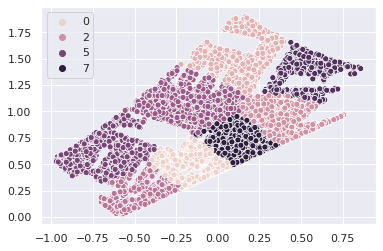

In [67]:
sns.scatterplot(positions[:,0], positions[:,1], hue=label)

In [69]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, n_jobs=-1)
mapping = tsne.fit_transform(latent[0].detach())

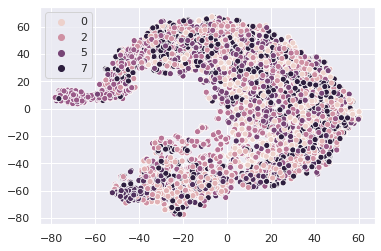

In [70]:
sns.scatterplot(mapping[:,0], mapping[:,1], hue=label)